# Prepare Data for TPZ

* query GCR with the same cuts we used for BPZ
* deredden the magnitudes 
* fill in missing values
* reformat to TPZ output

## Query GCR with the same cuts we used for BPZ

In [1]:
# everything we need for the whole notebook
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dustmaps
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from dustmaps.config import config
import GCRCatalogs
from GCR import GCRQuery

In [3]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6a')

In [4]:
tract_ids = [2731, 2904, 2906, 3081, 3082, 3084,
             3262, 3263, 3265, 3448, 3450, 3831,
             3832, 3834, 4029, 4030, 4031, 2905,
             3083, 3264, 3449, 3833]

basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'), # Bad centroiding
    GCRQuery('snr_i_cModel >= 10'),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts 
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped')
]

mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 25.',
]


allcols = ['ra','dec','blendedness','extendedness','clean','objectId','tract','patch']
for band in ('u','g','r','i','z','y'):
    allcols.append(f"mag_{band}_cModel")
    allcols.append(f"magerr_{band}_cModel")
    allcols.append(f"snr_{band}_cModel")
print(allcols)

['ra', 'dec', 'blendedness', 'extendedness', 'clean', 'objectId', 'tract', 'patch', 'mag_u_cModel', 'magerr_u_cModel', 'snr_u_cModel', 'mag_g_cModel', 'magerr_g_cModel', 'snr_g_cModel', 'mag_r_cModel', 'magerr_r_cModel', 'snr_r_cModel', 'mag_i_cModel', 'magerr_i_cModel', 'snr_i_cModel', 'mag_z_cModel', 'magerr_z_cModel', 'snr_z_cModel', 'mag_y_cModel', 'magerr_y_cModel', 'snr_y_cModel']


In [5]:
object_df_list = []
for i in tract_ids:
    print("reading tract {}".format(i))
    object_data = object_cat.get_quantities(allcols,
                                      filters=basic_cuts+mag_filters, native_filters=['tract == {}'.format(i)])
    object_df_list.append(pd.DataFrame(object_data))
coadd_df = pd.concat(object_df_list)

reading tract 2731
reading tract 2904
reading tract 2906


/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:44: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


reading tract 3081
reading tract 3082
reading tract 3084
reading tract 3262
reading tract 3263
reading tract 3265
reading tract 3448
reading tract 3450
reading tract 3831
reading tract 3832
reading tract 3834
reading tract 4029
reading tract 4030
reading tract 4031
reading tract 2905
reading tract 3083
reading tract 3264
reading tract 3449
reading tract 3833


In [8]:
## Deredden the magnitudes
band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31])
filters = ['u','g','r','i','z','y']
coords = SkyCoord(coadd_df['ra'], coadd_df['dec'], unit='deg', frame='fk5')
sfd = SFDQuery()
ebvvec = sfd(coords)
coadd_df['ebv'] = ebvvec

for ebv, filt in zip(band_a_ebv, filters):
    coadd_df['mag_{}_cModel_dered'.format(filt)] = coadd_df['mag_{}_cModel'.format(filt)] - coadd_df['ebv']*ebv

## Fill in missing values

In [9]:
bands = ['u','g','r','i','z','y']
patches = np.unique(coadd_df['patch'])

In [10]:
def impute_nan_mags(df, verbose=False):
    for ii,band in enumerate(bands):
        #add dereddened magnitudes and re-calculate log version of errors    
    #    deredden_mag = ebv_vec*band_a_ebv[ii]
    #    cmod_dered =df[f"mag_{band}_cModel"] - deredden_mag
    #    df[f"cModel_{band}_obj_dered"]=cmod_dered
        invsn = 1./df[f"snr_{band}_cModel"]
        logmagerr = 2.5*np.log10(1.+invsn)
        df[f"magerrlog_{band}_dered"] = logmagerr

        #now, replace the non-detections in each band with 99.0 for mag and
        #the 1 sigma limit determined from 1 sigma objects in the same band
        #do this patch by patch to partially account for variable depth/conditions!
        siglow = 0.73
        sighigh = 0.77
        defaultlimmag = 25.8
        for patch in patches:
            goodpatch = True
            sigselect = ((df[f'magerrlog_{band}_dered']>siglow) & (df[f'magerrlog_{band}_dered']<sighigh) \
                         & (df['patch']==patch)\
                         & (np.isfinite(df[f'mag_{band}_cModel_dered'])))
            if np.sum(sigselect)==0:
                siglow = 0.71
                sighigh = 0.79
                sigselect = ((df[f'magerrlog_{band}_dered']>siglow) & (df[f'magerrlog_{band}_dered']<sighigh) \
                             & (df['patch']==patch)\
                             & (np.isfinite(df[f'mag_{band}_cModel_dered'])))
            if np.sum(sigselect)==0:
                print(f"bad data in patch {patch} for band {band}: no 1 sig objects, put in hard coded 25.8 limit")
                goodpatch = False
            if verbose: print(f"{np.sum(sigselect)} total in cut for patch {patch}")
            if goodpatch:
                sigmag = df[f'mag_{band}_cModel_dered'][sigselect]
                limmag = np.median(sigmag)
                defaultlimmag = limmag
            else:
                limmag = 25.8 #hardcoded temp solution
            if verbose: print(f"1 sigma mag for patch {patch} in band {band} is {limmag}")
            #find all NaN and Inf and replace with mag = 99 and magerr = 1 sigma limit
            nondet = ((~np.isfinite(df[f'mag_{band}_cModel_dered']) | (~np.isfinite(df[f'magerrlog_{band}_dered']))) \
                      & (df['patch']==patch))
            df[f'mag_{band}_cModel_dered'][nondet] = limmag #changed by ih
            df[f'magerrlog_{band}_dered'][nondet] = .7525 #changed by ih
            if verbose: print(f"replacing inf and nan for {np.sum(nondet)} {band} band detects for patch {patch}")
    return df

In [11]:
impute_coadd_df = impute_nan_mags(coadd_df, verbose=True)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


254 total in cut for patch 0,0
1 sigma mag for patch 0,0 in band u is 27.233279154365672


/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-pyarrow/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


replacing inf and nan for 3259 u band detects for patch 0,0
228 total in cut for patch 0,1
1 sigma mag for patch 0,1 in band u is 27.29028699929129
replacing inf and nan for 3051 u band detects for patch 0,1
307 total in cut for patch 0,2
1 sigma mag for patch 0,2 in band u is 27.304898347269518
replacing inf and nan for 3402 u band detects for patch 0,2
266 total in cut for patch 0,3
1 sigma mag for patch 0,3 in band u is 27.273405342266962
replacing inf and nan for 3601 u band detects for patch 0,3
295 total in cut for patch 0,4
1 sigma mag for patch 0,4 in band u is 27.303602298854493
replacing inf and nan for 3171 u band detects for patch 0,4
271 total in cut for patch 0,5
1 sigma mag for patch 0,5 in band u is 27.282532987102226
replacing inf and nan for 3068 u band detects for patch 0,5
251 total in cut for patch 0,6
1 sigma mag for patch 0,6 in band u is 27.3089056757361
replacing inf and nan for 2736 u band detects for patch 0,6
311 total in cut for patch 1,0
1 sigma mag for pa

Text(0, 0.5, 'Magnitude error')

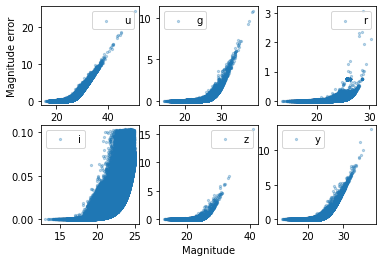

In [13]:
f, ax = plt.subplots(nrows=2, ncols=3)

for a, band in zip(ax.flatten(),bands):
    a.scatter(impute_coadd_df['mag_{}_cModel_dered'.format(band)],
              impute_coadd_df['magerrlog_{}_dered'.format(band)], s=5, alpha=.3,
             label='{}'.format(band))
    a.legend()

ax[1,1].set_xlabel('Magnitude')
ax[0,0].set_ylabel('Magnitude error')

## Reformat for TPZ input

In [14]:
len(impute_coadd_df)

2526042

In [15]:
features = {
            'u':impute_coadd_df['mag_u_cModel_dered'].values,
            'g':impute_coadd_df['mag_g_cModel_dered'].values,
            'r':impute_coadd_df['mag_r_cModel_dered'].values,
            'i':impute_coadd_df['mag_i_cModel_dered'].values,
            'z':impute_coadd_df['mag_z_cModel_dered'].values,
            'y':impute_coadd_df['mag_y_cModel_dered'].values,
            'u-g':impute_coadd_df['mag_u_cModel_dered'].values - impute_coadd_df['mag_g_cModel_dered'].values,
            'g-r':impute_coadd_df['mag_g_cModel_dered'].values - impute_coadd_df['mag_r_cModel_dered'].values,
            'r-i':impute_coadd_df['mag_r_cModel_dered'].values - impute_coadd_df['mag_i_cModel_dered'].values,
            'i-z':impute_coadd_df['mag_i_cModel_dered'].values - impute_coadd_df['mag_z_cModel_dered'].values,
            'z-y':impute_coadd_df['mag_z_cModel_dered'].values - impute_coadd_df['mag_y_cModel_dered'].values,
            'eu':impute_coadd_df['magerrlog_u_dered'].values,
            'eg':impute_coadd_df['magerrlog_g_dered'].values,
            'er':impute_coadd_df['magerrlog_r_dered'].values,
            'ei':impute_coadd_df['magerrlog_i_dered'].values,
            'ez':impute_coadd_df['magerrlog_z_dered'].values,
            'ey':impute_coadd_df['magerrlog_y_dered'].values,
            'ra':impute_coadd_df['ra'].values,
            'dec':impute_coadd_df['dec'].values,
            'objectId':impute_coadd_df['objectId'].values
            }

In [16]:
pd.DataFrame(features).to_csv('/global/cfs/cdirs/lsst/groups/PZ/PZBLEND/Run2.2i_dr6_dered_test.txt',
                              sep=' ', index=False, header=False, float_format='%.7g')